# Reduction of GIANO data

In [1]:
#------ manually fix import for now
import sys, os
sys.path.append('../src/')
#------
import numpy as np
import matplotlib.pyplot as plt
import glob
from astropy.io import fits
from redcross.read import read_giano
from redcross.datacube import Datacube
from redcross.cross_correlation import CCF, KpV, Template
from redcross.align import Align
from redcross.planet import Planet

def sysrem_evolution(snr_sys, outname=None):
    '''given a matrix with (SysRem iteration, SNR) 
    plot the evolution and highlight the max SNR'''
    sys_i = snr_sys.T[0]
    snr_i = snr_sys.T[1]

    fig, ax = plt.subplots(1, figsize=(9,4))
    ax.plot(sys_i, snr_i, '--', c='gray')
    ax.plot(sys_i, snr_i, 'o', markersize=7, c='k')

    snr_max = snr_i.max()
    ax.scatter(sys_i[snr_i.argmax()], snr_i.max(), marker='*', 
               color='orange', s=250, zorder=10, 
               label='Max SNR = {:.2f} \nn = {:.0f}'.format(snr_i.max(), sys_i[snr_i.argmax()]))
    ax.set(xlabel='SysRem iteration', ylabel='SNR', title='Evolution of SNR with SysRem iterations')
    ax.legend()
    plt.show()
    if outname != None:
        fig.savefig(outname, dpi=200, bbox_inches='tight', facecolor='white')
    return None

c = 2.99e5
%load_ext autoreload
%autoreload 2

In [2]:
night = '1'
position = 'B'
data_dir = '/home/dario/AstronomyLeiden/MRP/wasp189/data/giano/night{:}/pos{:}/'.format(night, position)

# dc = Datacube().load(data_dir+'datacube_input_pos{:}.npy'.format(position))

read_from_files = False # set to `True` the first time running it

if read_from_files:
    files = sorted(glob.glob(data_dir+'*_{:}_*.fits'.format(position))) # select files
    dc = read_giano(files)
    dc.save(data_dir+'datacube_input_pos{:}.npy'.format(position))
else:
    dc = Datacube().load(data_dir+'datacube_input_pos{:}.npy'.format(position))
    
planet = Planet('wasp189')
planet.BERV = dc.BERV
planet.MJD = dc.MJD

Loading Datacube from... /home/dario/AstronomyLeiden/MRP/wasp189/data/giano/night1/posB/datacube_input_posB.npy


total/out-of-eclipse
84 / 0


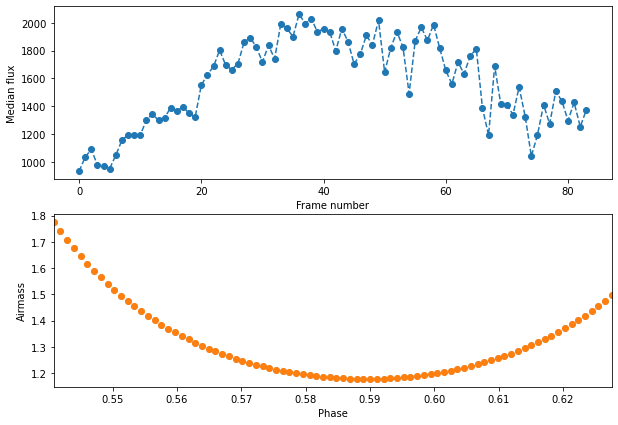

In [3]:
fig, ax = plt.subplots(2,1, figsize=(10,7))

flux = np.median(dc.flux, axis=(0,2))
ax[0].plot(np.arange(0, dc.nObs), flux ,'--o')

ax[1].plot(planet.phase, dc.airmass,'o', alpha=0.3)
ax[1].plot(planet.phase, dc.airmass,'o')
ax[1].axvspan(0.46, 0.54, alpha=0.1, color='red', label='Eclipse')
ax[1]

ax[0].set(ylabel='Median flux', xlabel='Frame number')
ax[1].set(xlabel='Phase', ylabel='Airmass', xlim=(planet.phase.min(), planet.phase.max()))

# how many frames are in-eclipse
ecl = planet.phase > 0.47
print('total/out-of-eclipse')
print('{:} / {:}'.format(planet.phase.size, planet.phase[~ecl].size))

# discard frames with very-low flux
# mask = flux < 200
# bad_files = int(np.argwhere(mask==True)[0])
# files[bad_files]

(50, 84, 2048)
(100, 84, 1024)
--> 3.32 % of pixels masked
--> 8.79 % of pixels masked


/home/dario/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dario/AstronomyLeiden/MRP/redcross/examples/../src/redcross/datacube.py:171: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(self.flux, axis=axis)


outliers = 6.41e-03 %
--> 2.44 % of pixels masked


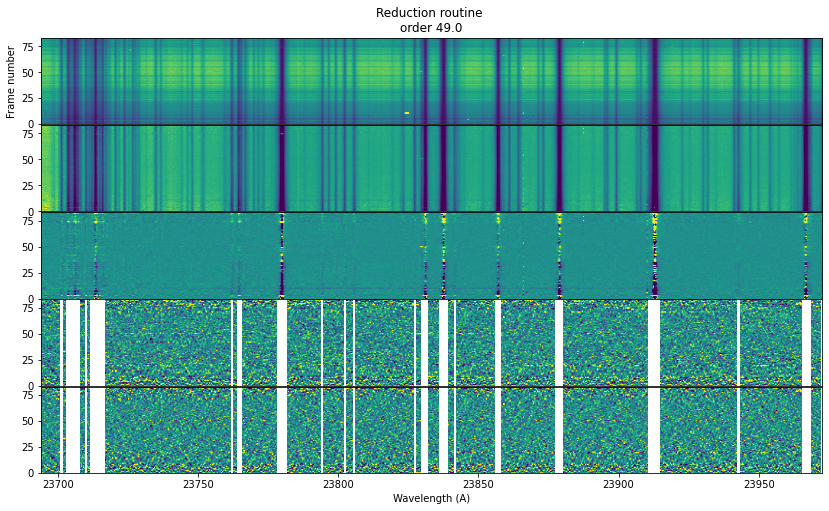

In [4]:
%matplotlib inline
fig, ax = plt.subplots(5,figsize=(14,8))
plt.subplots_adjust(hspace=0.01)

# First select an order
dcx = dc.split_orders(debug=True)
order = 98
dco = dcx.order(order)


apply_wave_sol = False
if apply_wave_sol:
    order_int = int(order/2.)
    wave_sol = np.load('data/wave_sol/night{:}_pos{:}_order{:}.npy'.format(night, position, order_int))
    x = int(wave_sol.size / 2.)
    if (order-order_int) > 0:
        dco.wlt = wave_sol[x:]
    else:
        dco.wlt = wave_sol[:x]
else:
    dco.wlt = np.median(dco.wlt, axis=0)
    
    

# Original
dco.imshow(ax=ax[0])

# Remove continuum
dco.remove_continuum().sigma_clip()



# Inject signal
factor = 0. # strenght of the injection (1 is the expected planetary signal, set to 0 to ignore this step)
if factor > 0:
    dco.inject_signal(planet, template, factor=factor)

# dco.sigma_clip(debug=True)
dco.imshow(ax=ax[1])

# Airmass detrend
dco.airmass_detrend()
s = 2.
dco.imshow(ax=ax[2], stretch=s)

#   TESTING
debug = True
dco.mask_cols(sigma=1.0, mode='flux', nan=True, debug=debug)
dco.mask_cols(sigma=1.0, mode='flux_err', nan=True, debug=debug)

# SysRem
dco.sysrem(8)
dco.imshow(ax=ax[3], stretch=s)

# High-pass filter
dco.high_pass_gaussian(15) # window in [pixels]
dco.imshow(ax=ax[4], stretch=s)

#     # 6. Sigma-clip again
dco.sigma_clip(nSigma=3., debug=debug)
# 7. Mask noisy columns
dco.mask_cols(sigma=3., mode='flux_err', nan=True, debug=debug)

[ax[k].set_xticks([]) for k in range(3)]
ax[0].set(ylabel='Frame number', title='Reduction routine \norder {:}'.format(order/2))
ax[len(ax)-1].set(xlabel='Wavelength (A)')


plt.show()
outname = 'plots/reduction_routine_order{:}.png'.format(order/2.)
# fig.savefig(outname, dpi=200, bbox_inches='tight', facecolor='white')

In [5]:
# def my_reduction(dco=None):
#     dco.align()
#     dco.wlt = np.median(dco.wlt, axis=0)
#     dco.remove_continuum().sigma_clip()
    
#     dco.airmass_detrend().sysrem(10).high_pass_gaussian(15)
#     dco.mask_cols(sigma=1.5, mode='flux', nan=True, debug=True)
#     return dco
# dc = Datacube().load(data_dir+'datacube_input_pos{:}.npy'.format(position))

# # datacube reduced 
# dcx = dc.split_orders(debug=True)

# orders = np.arange(48*2,50*2)
# print(orders)
# dcr = dcx.reduce_orders(my_reduction, orders, num_cpus=2)

In [6]:
# species = 'OH_main_iso'
species = 'CO_main_iso'
template_path = 'data/template_giano_{:}_2500K.npy'.format(species)
twave, tflux = np.load(template_path)

# flux must be continuum subtracted (normalised)
template = Template(wlt=twave, flux=tflux)

[[ 0 25 26 27 39 40 41]]


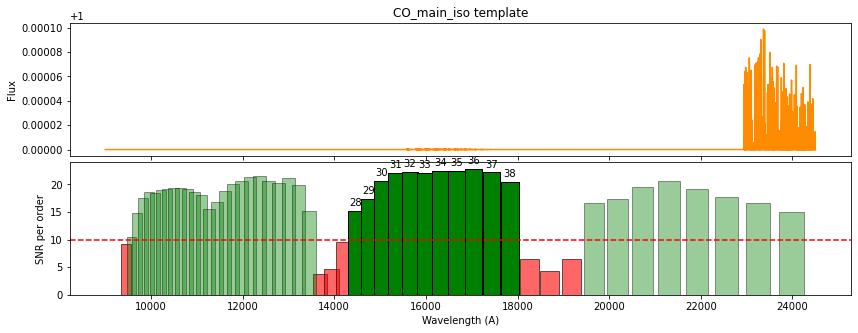

In [7]:
dc.flux_err[dc.flux_err==0.] = np.nan
snr_order = np.nanmedian(dc.flux/dc.flux_err, axis=(1,2))
cenwave = np.median(dc.wlt, axis=(1,2))
wave_per_order = np.median(dc.wlt, axis=1)
widths = np.array([wave_per_order[x,:].max()-wave_per_order[x,:].min() for x in range(wave_per_order.shape[0])])

# SNR treshold
th = 10.
mask_orders = snr_order < th 

fig, ax = plt.subplots(2,1, figsize=(14,5), sharex=True)
# plt.rcParams.update({'font.size':14})
plt.subplots_adjust(hspace=0.05)
# plt.style.use('default')

ax[0].plot(template.wlt, template.flux, c='darkorange')
# bar plot for order-weights 

ax[1].bar(cenwave[mask_orders], snr_order[mask_orders], fc='red', width=widths[mask_orders], edgecolor='k', alpha=0.6)
ax[1].bar(cenwave[~mask_orders], snr_order[~mask_orders], fc='green', width=widths[~mask_orders], edgecolor='k', alpha=0.4)
print(np.argwhere(mask_orders==True).T)


######## SELECT ORDERS ########
orders = np.arange(28,39)
selected_orders = ax[1].bar(cenwave[orders], snr_order[orders], fc='green', width=widths[orders], edgecolor='k', alpha=1.)
ax[1].bar_label(selected_orders, labels=orders, padding=3)


ax[1].axhline(th, ls='--', c='r')
# settings
ax[0].set(ylabel='Flux', title='{:} template'.format(species))
ax[1].set(xlabel='Wavelength (A)', ylabel='SNR per order')
plt.show()

Loading Datacube from... /home/dario/AstronomyLeiden/MRP/wasp189/data/giano/night1/posB/datacube_input_posB.npy
(2, 84, 2048)
(4, 84, 1024)
---7/15----
Order 48


mkdir: cannot create directory ‘plots/giano_CO_night1_posB/’: File exists


outliers = 6.39e-04 %
--> 6.54 % of pixels masked
--> 5.27 % of pixels masked


/home/dario/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dario/AstronomyLeiden/MRP/redcross/examples/../src/redcross/datacube.py:171: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(self.flux, axis=axis)


outliers = 4.62e-03 %
--> 0.49 % of pixels masked
Initial pixel channels = 1024
Output pixel channels = 898
Order 49
outliers = 5.46e-04 %
--> 6.35 % of pixels masked
--> 5.08 % of pixels masked
outliers = 4.05e-03 %
--> 0.39 % of pixels masked
Initial pixel channels = 1024
Output pixel channels = 903
Order 50
outliers = 9.77e-04 %
--> 2.93 % of pixels masked
--> 3.81 % of pixels masked
outliers = 7.89e-03 %
--> 3.12 % of pixels masked
Initial pixel channels = 1024
Output pixel channels = 923
Horizontal slice at Kp = 198.1 km/s
Vertical slice at Vrest = 3.7 km/s


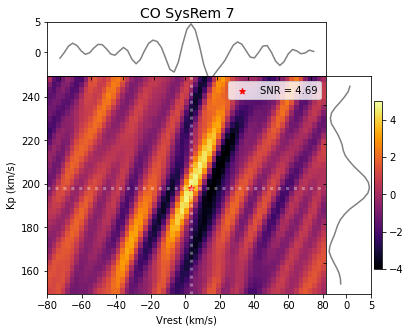

In [12]:
def reduce_giano(dco_in, nSysRem=3, hpw=15, debug=False):
    dco = dco_in.copy()
    
    # 0. Align frames
    dco.remove_continuum(mode='polyfit')
#     dco.align()
    dco.wlt = np.median(dco.wlt, axis=0)
    
    good_in = dco.wlt[~np.isnan(dco.wlt)].size
    # 1. Remove continuum by dividing by a 3rd order polynomial fit
#     dco.remove_continuum(mode='polyfit')
    # 2. Sigma-clip flux data points beyond 3-sigma
    dco.sigma_clip(debug=debug)
    # 3. Airmass detrend (divide by 2nd order polyfit)
    dco.airmass_detrend()
    
#     # TESTING
    dco.mask_cols(sigma=1.2, mode='flux', nan=True, debug=debug)
    dco.mask_cols(sigma=2., mode='flux_err', nan=True, debug=debug)
#     # 4. SysRem
    if nSysRem > 0.:
        dco.sysrem(nSysRem)
#     # 5. High-pass filter
    dco.high_pass_gaussian(hpw, 'subtract')
#     # 6. Sigma-clip again
    dco.sigma_clip(nSigma=3., debug=debug)
    # 7. Mask noisy columns
    dco.mask_cols(sigma=3., mode='flux_err', nan=True, debug=debug)
    
    if debug:
        good_out = dco.wlt[~np.isnan(dco.wlt)].size
        print('Initial pixel channels = {:}'.format(good_in))
        print('Output pixel channels = {:}'.format(good_out))
        
    return dco

%matplotlib inline
dc = Datacube().load(data_dir+'datacube_input_pos{:}.npy'.format(position))
orders = [48,49]

# orders = np.arange(30,38)

dcs = dc.order(orders)

# wave_sols = np.zeros((2, dcs.nPix))
# for i,o in enumerate(orders):
#     wave_sols[i,] = (np.load('data/wave_sol/night{:}_pos{:}_order{:}.npy'.format(night, position, o)))
# dcs.wlt = wave_sols
dcs = dcs.split_orders(debug=True)


hpw = 15

dRV = 2.7
RVt = np.arange(-350,351, dRV)
dkp, kp_amp = dRV, 50 # km/s
vrest_amp, dvrest = 80, dRV # km /s
v_range = [-4.,5.0] # fix color scale

sysrem_its = np.arange(7,8)
snr_sys = np.zeros((sysrem_its.size,2))

# save sequence
create_gif = False
folder = 'plots/giano_{:}_night{:}_pos{:}/'.format(species.split('_')[0], night, position)
os.system("mkdir {:}".format(folder))
for k,nsys in enumerate(sysrem_its):
    print('---{:}/15----'.format(nsys))
    wave, flux, flux_err = ([] for _ in range (3))

#     for o in range(dcs.shape[0]):
    for o in range(3):
        print('Order {:}'.format(orders[0]+o))
        dco1 = reduce_giano(dcs.order(o), nsys, hpw, debug=True)

        wave.append(dco1.wlt) # changing the shape, can't overwrite for each order
        flux.append(dco1.flux)
        flux_err.append(dco1.flux_err)

    dcm = Datacube(flux=np.hstack(flux), wlt=np.hstack(wave), flux_err=np.hstack(flux_err))

    # As with HARPSN, we are essentially taking the median BERV shift 
    beta = 1 - np.median(dc.BERV)/c
    dcm.wlt *= beta

    ccf = CCF(rv=RVt, template=template).run(dcm, weighted=True)
    kpv = KpV(ccf, planet, [kp_amp, dkp], [vrest_amp, dvrest], bkg=50.)

    
    outname = folder+'sysrem-{:}.png'.format(nsys)
#     outname = None
    kpv.run().fancy_figure(peak=[2.5,197], outname=outname, title='CO SysRem {:}'.format(nsys), v_range=v_range)
    snr_sys[k,] = np.array([nsys, kpv.peak_snr])

# save sysrem plot
# sysrem_evolution(snr_sys, outname=folder+'sysrem_evolution.png')



if create_gif:
    os.system("echo Generating animation with sequence...")
    os.system('ffmpeg -hide_banner -loglevel quiet -framerate 1 -i {:}-%00d.png -vcodec libx264 -vf \
              "pad=ceil(iw/2)*2:ceil(ih/2)*2" -r 24  -y -an {:}output.mp4'.format(outname.split('-')[0], folder))
    os.system('ffmpeg -i {0:}output.mp4 -r 15 -vf scale=512:-1 {0:}output.gif'.format(folder))   

<IPython.core.display.Javascript object>


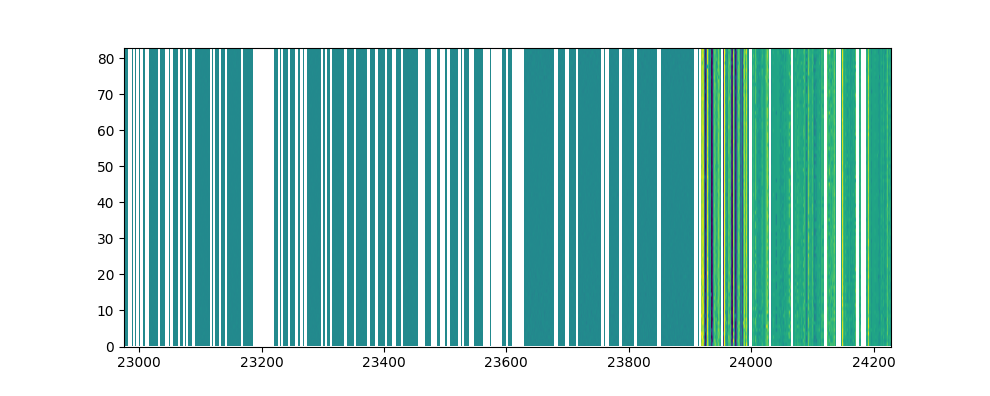

9.62 % of pixels have been masked


In [10]:
%matplotlib notebook
fig, ax = plt.subplots(1,figsize=(10,4))
dcm.imshow(ax=ax)
nans = np.isnan(dcm.wlt)
frac_masked = nans[nans==True].size / nans.size
print('{:.2f} % of pixels have been masked'.format(100*frac_masked))
plt.show()


In [11]:
print(stop)
dRV = 1.6
RVt = np.arange(-350,351, dRV)

ccf = CCF(rv=RVt, template=template)
ccf.run(dcm, weighted=True)



fig, ax = plt.subplots(1,3,figsize=(14,4))

ccf.imshow(ax=ax[0])
ccf_shifted = ccf.to_planet_frame(planet)
ccf_shifted.imshow(ax=ax[1])
ax[2].plot(ccf_shifted.rv, np.median(ccf_shifted.flux, axis=0))

[ax[k].set_xlabel('RV (km/s)') for k in range(3)]
ax[0].set(ylabel='Frame number', title='CCF (stellar frame)')
ax[1].set(title='CCF (planetary frame)')
ax[2].yaxis.tick_right()
ax[2].set(ylabel='CCF value', title='1D CCF (average over time)')

plt.show()

NameError: name 'stop' is not defined

In [ ]:
dkp, kp_amp = dRV, 50 # km/s
vrest_amp, dvrest = 80, dRV # km /s
kpv = KpV(ccf, planet, [kp_amp, dkp], [vrest_amp, dvrest], bkg=50.)
kpv.run()
kpv.fancy_figure(snr_max=True)
plt.show()